# Studying baseline datasets and their graph representation
In this notebook I will be looking at a number of metrics and statistics for the 
collection of datasets we are using for EmbDI. This notebook will be extended in
the future in order to test graph representations of tables generated with 
alternative methods.  

In [6]:
%load_ext autoreload
%autoreload 1
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/rcap/Projects/embdi


In [7]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
import random
import math
import networkx as nx
from EmbDI.graph import Graph
import csv
from EmbDI.utils import *
from EmbDI.edgelist import EdgeList


The class `StudyUnit` assumes that all files mentioned here have the same format,
and are in known folders in the directory tree.

Specifically, these are the paths of interest:
 - all datasets should follow the format: `pipeline/datasets/dataset_name/{dataset_name}-master.csv`. 
 - all information files should follow the format: `pipeline/info/info-{dataset_name}.txt`.
 - all matches files should follow the format: `pipeline/matches/matches-{dataset_name}.txt`.
 - all edgelists should follow the format: `pipeline/edgelists/{dataset_name}-edgelist.txt`.

 It is also possible to manually define the path of all files. 

In [8]:
from ast import DictComp
from pyparsing import MatchFirst

from EmbDI.graph import Edge
class StudyUnit:
    def __init__(self, dataset_name, 
        prefixes=["3#__tn", "3$__tt", "5$__idx", "1$__cid"],
        path_df=None,
        path_info=None,
        path_edgelist=None,
        path_matches=None
        ):
        """This class runs a number of estimations and metrics on the given 
        dataset, and on the graph that is built on top of the dataset.

        Args:
            dataset_name (str): Canonical name of the dataset.
            prefixes (list, optional): Prefixes that will be used to pilot the 
            graph construction algorithm and define the behavior of each class of 
            nodes. Defaults to ["3#__tn", "3", "5", "1"].
            path_df (str, optional): If provided, overrides the automated dataset
            path search based on the dataset name. Defaults to None.
            path_info (_type_, optional): If provided, overrides the automated 
            dataset information file path search based on the dataset name. 
            Defaults to None.
            path_edgelist (_type_, optional): If provided, overrides the 
            automated edgelist file path search based on the dataset name. Defaults 
            to None.
            path_matches (_type_, optional): If provided, overrides the automated
            match file path search based on the dataset name. Defaults to None.
        """
        # In manual assignent mode, all files must be provided. 
        assert all([path is None for path in 
                    [path_df, path_info, path_edgelist, path_matches]])
        
        self.read_dataframe(dataset_name, path_df)

        # bounds_datasets is the bound of the first dataset
        bounds_datasets = self.read_info_file(dataset_name, path_info)
        
        # 
        self.read_matches_file(dataset_name, path_matches)
        
        # Splitting the full (concatenated) dataframe in two based on bounds_datasets
        self.df1 = self.df[: bounds_datasets[0]]
        self.df2 = self.df[bounds_datasets[0] :]
        # Counting the unique values in the full dataset.
        counts = Counter(self.df.values.ravel())
        if np.nan in counts:
            counts.pop(np.nan)

        # Computing sats on the datasets (unique values and intersection)
        self.uniq_df1 = set(self.df1.values.ravel().tolist())
        self.uniq_df2 = set(self.df2.values.ravel().tolist())
        self.uniq_complete = self.uniq_df1.union(self.uniq_df2)
        self.intersection = self.uniq_df1.intersection(self.uniq_df2)
        # Overlapping columns (same label)
        self.ov_col = [_ for _ in self.df1.columns if _ in self.df2.columns]

        # Building the graph on top of the table according to the given prefixes
        self.build_graph(dataset_name, prefixes)

    def read_matches_file(self, dataset_name, path_file=None):
        """Utility function for reading the file that contains the ground truth
        matches for the ER task.

        Args:
            dataset_name (str): Canonical name of the dataset.
            path_file (str): Path to the graph file, if provided. 

        Raises:
            IOError: An exception is raised if the provided matches file does not exist.
        """
        if path_file is None:
            match_file = "pipeline/matches/er-matches/matches-{}.txt".format(dataset_name)
        try: 
            assert osp.exists(match_file)
            with open(match_file, "r") as fp:
                for ix, line in enumerate(fp):
                    pass
                self.matching_lines = ix
        except AssertionError:
            raise IOError(f'File {match_file} does not exist.')

    def read_info_file(self, dataset_name, path_info=None):
        """Utility function for reading the information file, which contains the
        boundary between the two datasets used in the ER task. 

        Args:
            dataset_name (str): Canonical name of the dataset
            path_info (str, optional): Path to the dataset. Defaults to None.

        Raises:
            IOError: An exception is raised if the provided info file does not exist. 

        Returns:
            _type_: The number of items in the first dataset (i.e. the boundary
            between the first and the second dataset).
        """
        if path_info is None:
            info_file = "pipeline/info/info-{}.txt".format(dataset_name)
        try: 
            assert osp.exists(info_file)
            with open(info_file, "r") as fp:
                n_items = {}
                for idx, line in enumerate(fp):
                    k, v = line.split(",")
                    n_items[idx] = int(v)
            return n_items
        except AssertionError:
            raise IOError(f'File {info_file} does not exist.')


    def read_dataframe(self, dataset_name, path_file):
        
        if path_file is None:
            path_file = str("pipeline/datasets/{}/{}-master.csv".format(dataset_name, dataset_name))
        try:
            assert osp.exists(path_file)
            self.df = pd.read_csv(path_file, dtype=str)
        except AssertionError:
            raise IOError(f'File {path_file} does not exist.')
        
    def read_edgelist_file(self, dataset_name, path_edgelist):
        if path_edgelist is None:
            edgelist_file = "pipeline/edgelists/{}-er-edgelist.txt".format(dataset_name)
        try:
            assert osp.exists(edgelist_file)
        except AssertionError:
            raise IOError(f'File {edgelist_file} does not exist.')

        return edgelist_file

    def build_graph(self, dataset_name, prefixes=["3#__tn", "3$__tt", "5$__idx", "1$__cid"]):
        """Utility function that builds the graph on top of the given table, and 
        sets the prefixes. 


        Args:
            dataset_name (str): Canonical name of the dataset.
            prefixes (list, optional): _description_. Defaults to ["3#__tn", "3", "5", "1"].
        """
        if prefixes is None:
            prefixes = edgelist.get_prefixes()
        edgelist = EdgeList(self.df)

        g = Graph(edgelist.get_edgelist(), prefixes=prefixes, flatten=["tt"])

        self.nxg = g.convert_to_nx()


    def edges_by_node(self):
        """This function counts the number of edges for each node, splitting the 
        nodes by their type (RID, CID, tt, tn).

        Raises:
            ValueError: An exception is raised if one of the prefixes is not recognized.

        Returns:
            dict: Dictionary that contains all the node counts, split by node 
            type.
        """
        ebn = {
            'tt': {},
            'rid': {},
            'cid': {},
            'tn' : {}
               }
        for node in self.nxg.nodes():
            edges_this_node = len(self.nxg.edges(node))
            if node.startswith('idx__'):
                ebn["rid"][node] = edges_this_node
            
            elif node.startswith('cid__'):
                ebn["cid"][node] = edges_this_node
            
            elif node.startswith('tt__'):
                ebn["tt"][node] = edges_this_node
            
            elif node.startswith('tn__'):
                ebn["tn"][node] = edges_this_node
            else:
                raise ValueError(f'Unknown type of node {node}.')
            
        return ebn

    def get_basic_info(self):
        """Print basic information on the table: shape, matching columns, 
        overlapping columns and values. 

        Returns:
            list: List of metrics. 
        """
        info_labels = [
            'num_rows',
            'num_cols',
            'len_gt',
            'overlapping_columns',
            'overlapping_values',
            'frac_overlapping_values'
        ]
        info = [
            len(self.df),
            len(self.df.columns),
            self.matching_lines,
            len(self.ov_col),
            len(self.intersection),
            100 * (len(self.intersection) / len(self.uniq_complete)),
        ]
        return {iv: value for iv, value in zip(info_labels,info)}

    def get_graph_info(self):
        """This function measures a number of metrics relative to the table graph
        and stores them in a dictionary.

        Returns:
            dict: Dictionary containing all the metrics calculated here. 
        """
        ebn = self.edges_by_node()
        # We're only interested in categorical cell nodes. 
        # TODO: extend to other types of nodes.
        ebn_tt = ebn['tt']
        # Sorting nodes by their degree
        edge_count_by_node = sorted([ebn_tt[_] for _ in ebn_tt], reverse=True)
        edge_count_by_node = np.array(edge_count_by_node)

        # Computing metrics
        total_nodes = len(edge_count_by_node)
        avg_degree = np.average(edge_count_by_node)
        sum_degree = np.sum(edge_count_by_node)
        max_degree = max(edge_count_by_node)
        # 99th percentile: all nodes have a degree lower than this value.
        perc99 = np.percentile(edge_count_by_node, 99)
        # All nodes whose degree is larger than perc99
        nodes_above_perc = edge_count_by_node[edge_count_by_node > perc99]
        # Number of edges connected to the nodes above perc99
        edges_from_nodes_above_perc = sum(nodes_above_perc)
        # Average degree of nodes above perc99
        avg_deg_above_perc = np.average(nodes_above_perc)

        info_dict = {
            'total_nodes': total_nodes,
            'avg_degree': avg_degree,
            'sum_degree': sum_degree,
            'max_degree': max_degree,
            'perc99': perc99,
            'nodes_above_perc': len(nodes_above_perc),
            'edges_from_nodes_above_perc': edges_from_nodes_above_perc,
            'avg_deg_above_perc': avg_deg_above_perc,
            'edge_count_by_node': edge_count_by_node
        }

        return info_dict

    def print_basic_info(self):
        print("Overall number of lines: {}".format(len(self.df)))
        print("Overall number of columns: {}".format(len(self.df.columns)))
        print("Overall distinct values: {}".format(len(self.uniq_complete)))
        print("Values in Ground Truth: {}".format(self.matching_lines))
        print("Overlapping columns: {}".format(len(self.ov_col)))
        print("Overlapping values: {}".format(len(self.intersection)))
        print("Unique elements in dataset 1: {}".format(len(self.uniq_df1)))
        print("Unique elements in dataset 2: {}".format(len(self.uniq_df2)))
        print("Values in common between dataset 1 and dataset 2: {}".format(len(self.intersection)))
        print("Fraction of values in common: {:.2f}%".format(100 * (len(self.intersection) / len(self.uniq_complete))))
        print("{:30}{:20}".format("Dataset 1 Rows:", len(self.df1)))
        print("{:30}{:20}".format("Dataset 1 Columns:", len(self.df1.columns)))
        print("{:30}{:20}".format("Dataset 2 Rows:", len(self.df2)))
        print("{:30}{:20}".format("Dataset 2 Columns:", len(self.df2.columns)))
        print("{:30}{:20}".format("Combined Dataset Rows:", len(self.df)))
        print("{:30}{:20}".format("Combined Dataset Columns:", len(self.df.columns)))

    def print_graph_info(self, info):
        
        print("Total nodes: {}".format(info['total_nodes']))
        print("Average degree: {:.2f}".format(info['avg']))
        print("Total tt edges: {}".format(info['sum_degree']))
        print("Max degree: {}".format(info['max_degree']))
        print("Degree 99-th percentile: {:.2f}".format(info['perc']))
        print("Degree 99-th perc/n edges: {:.4f}%".format(info['perc'] / info['sum_degree'] * 100))
        print("Nodes with degree above 99-th perc: {}".format(len(info['nodes_above_perc'])))
        print("Number of edges connected to nodes above 99th perc: {}".format(info['edges_from_nodes_above_perc']))
        print("% of edges connected to high degree nodes, "
              "as factor of total edges: {:.2f}%".format(info['edges_from_nodes_above_perc'] / info['sum_degree'] * 100))
        print("Average degree above percentile: {:.2f}".format(info['avg_deg_above_perc']))



In [10]:
study_unit_dict = {}
# dataset_list = ['amazon_google', 'walmart_amazon', 'itunes_amazon', 'imdb_movielens', 'dblp_scholar', 'fodors_zagats', 'dblp_acm', 'beer']
dataset_list = ['imdb_movielens']
info_by_dataset = {x: None for x in dataset_list}
for dset in dataset_list:
    study_unit = StudyUnit(dset)
    study_unit_dict[dset] = study_unit
    info_by_dataset[dset] = {}
    info_basic = study_unit.get_basic_info()
    info_graph = study_unit.get_graph_info()
    info_by_dataset[dset].update(info_basic)
    info_by_dataset[dset].update(info_graph)


49875it [00:07, 6739.21it/s]



# Expanding columns: [tt].


# Preparing aliased randomizer.: 100%|██████████| 232329/232329 [00:06<00:00, 34734.75it/s]


In [80]:
from numpy import mean

columns = [
    'Dataset name',
    'Num rows',
    'Num columns',
    'Overlapping columns',
    'Overlapping values',
    'Fraction overlapping values',
    'Total nodes', 
    'Average degree',
    'Total tt edges',
    '99th percentile degree',
    'Nodes above 99th',
    'Edges in 99th',
    'Avg degree in 99th'
]
def info_dict_to_list(dset_name, info_dict):
    info_list = [
        dset_name,
        info_dict['num_rows'],
        info_dict['num_cols'],
        info_dict['overlapping_columns'],
        info_dict['overlapping_values'],
        info_dict['frac_overlapping_values'],
        info_dict['total_nodes'],
        info_dict['avg_degree'],
        info_dict['sum_degree'],
        info_dict['perc99'],
        info_dict['nodes_above_perc'],
        info_dict['edges_from_nodes_above_perc'],
        info_dict['avg_deg_above_perc'],    
    ]
    return info_list

data_dict = {}
for idx, (dataset, info) in enumerate(info_by_dataset.items()):
    info_list = info_dict_to_list(dataset, info)
    data_dict[idx]=info_list

info_df = pd.DataFrame.from_dict(data_dict, orient='index', columns=columns)
info_df


,Dataset name,Num rows,Num columns,Overlapping columns,Overlapping values,Fraction overlapping values,Total nodes,Average degree,Total tt edges,99th percentile degree,Nodes above 99th,Edges in 99th,Avg degree in 99th
0,amazon_google,4589,3,3,324,6.011132,10167,4.999115,50826,53.00,100,14264,142.640000
1,walmart_amazon,24628,5,5,1408,3.097637,69856,7.212938,503867,93.00,698,239785,343.531519
2,itunes_amazon,62830,8,8,2534,4.725320,71647,23.745977,1701328,276.00,716,1032941,1442.655028
3,imdb_movielens,49875,15,15,10446,8.797891,180943,7.155430,1294725,59.00,1793,520805,290.465700
4,dblp_scholar,66879,4,4,3053,2.328774,231998,6.165394,1430359,52.00,2307,745155,322.997399
5,fodors_zagats,864,6,6,298,9.079829,3434,4.110949,14117,41.34,35,4483,128.085714
6,dblp_acm,4910,7,7,4086,62.334096,14803,8.399041,124331,64.00,147,42942,292.122449
7,beer,7345,4,4,1146,10.177620,18123,5.891188,106766,29.00,177,49832,281.536723


In [81]:
def normalize(x):
    min_x = min(x)
    max_x = max(x)
    return (x-min_x)/(max_x-min_x)


In [82]:
ebn = info_by_dataset['amazon_google']['edge_count_by_node']

Plotting the degree distribution of cell nodes for each dataset. 

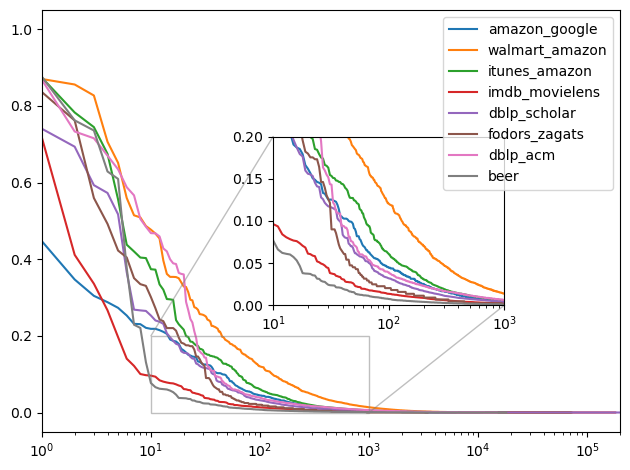

In [83]:
fig, axs = plt.subplots()
for dataset, info_dict in info_by_dataset.items():
    y = info_dict['edge_count_by_node']
    norm_y = normalize(y)
    axs.semilogx(norm_y, label=dataset)
    axs.set_xlim([1, 2e5])

axins = axs.inset_axes([0.4, 0.3, 0.4, 0.4])
for dataset, info_dict in info_by_dataset.items():
    y = info_dict['edge_count_by_node']
    norm_y = normalize(y)
    axins.semilogx(norm_y)
    x1,x2,y1,y2 = 1e1, 1e3, 0, 0.2
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    
axs.indicate_inset_zoom(axins)
plt.legend()
plt.tight_layout()

### Studying smoothing functions
TODO: fixing everything below this point

In [18]:
def smooth_freq(freq, s=0.2, k=0.05, target=200, eps=0.01):
    return smooth_exp(freq, eps, target, k, s)

def smooth_exp(x, eps, target, k, s):
    t = (eps/(1-s))**(k/(1-target))
    y = (1-s) * t ** (-1/k*x + 1/k) + s    
    return y

def f_log(x, b=10):
    log_b = np.log10(x) / np.log10(b)
    return 1/(log_b+1)

def smooth_exp_v2(x, target, s):
    b = (1/2) ** (1/(1-target))
    y = (1-s) * b ** (-1*x + 1) + s
    return y

def smooth_freq_v2(freq, s=0.2, target=200):
    return smooth_exp_v2(freq,target,s)

def inverse(x):
    return 1/x

def inverse_smooth(x, s):
    y = (1/2) * ((s-1) * math.e ** (1-x) + 2 - s)
    return y

In [19]:
g = nx.Graph()

Average degree: 5.11
Total rid edges: 607210
Skewness: 166.64
Kurtosis: 33269.25


/Users/rcap/opt/anaconda3/envs/embdi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


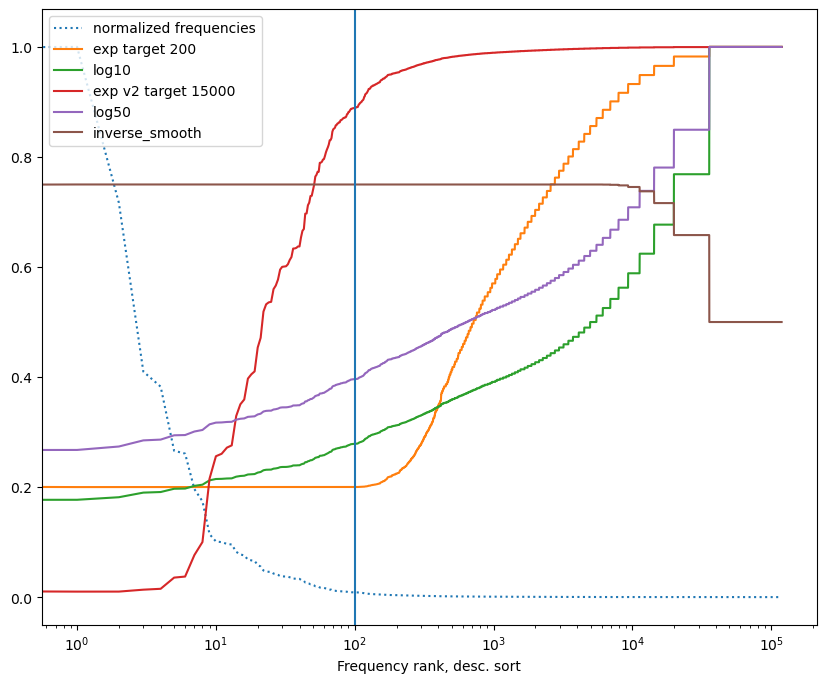

<Figure size 1000x600 with 0 Axes>

In [21]:
path_df = str('pipeline/datasets/original_er_datasets/imdb_movielens.csv')
df = pd.read_csv(path_df, dtype=str)

counts = Counter(df.values.ravel())
if np.nan in counts:
    counts.pop(np.nan)

len(counts)

v = counts.most_common()

v1 = [_[1] for _ in v]
v1 = [0]*1 + v1

v1 = np.array(v1)
vmovies = v1

avg = np.average(v1)
print('Average degree: {:.2f}'.format(avg))
sumdeg = np.sum(v1)
print('Total rid edges: {}'.format(sumdeg))

norm_v1 = normalize(v1)
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
# plt.loglog(v1)

plt.semilogx(norm_v1, label='normalized frequencies', ls=':')

# plt.xlim([0, 1000])
# fig = plt.figure()
y1 = smooth_freq(v1)
y2 = f_log(v1)
y3 = smooth_freq(v1, target=15000, s=0.01)
y4 = f_log(v1, 50)
y5 = inverse_smooth(v1, 0.5)

plt.semilogx(y1, label='exp target 200')
plt.semilogx(y2, label='log10')
plt.semilogx(y3, label='exp v2 target 15000')
plt.semilogx(y4, label='log50')
plt.semilogx(y5, label='inverse_smooth')

plt.xlabel('Frequency rank, desc. sort')
plt.legend()
ax.axvline(100)
# plt.xlim([0.1,10e5])
fig = plt.figure(figsize=(10,6))
print('Skewness: {:.2f}'.format(stats.skew(v1)))
print('Kurtosis: {:.2f}'.format(stats.kurtosis(v1)))